# Test for ForrestAtRsik to use Google Earth Engine using Xee 

This is a simple test to see if ForrestAtRisk can use Google Earth Engine data 1) without credentials (no authentication) and 2) using Xee (https://github.com/google/Xee) and the xarray framework.

In [21]:
import ee
import xarray as xr
import rioxarray
from osgeo import ogr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

Google initilization

In [2]:
ee.Initialize()

Area of study: let's go with Martinique.

In [3]:
iso3 = "MTQ"
shp_name = "data_raw/gadm36_" + iso3 + "_0.shp"

Some usefull function

In [4]:
def extent_shp(inShapefile):
    """Compute the extent of a shapefile.

    This function computes the extent (xmin, xmax, ymin, ymax) of a
    shapefile.

    :param inShapefile: Path to the input shapefile.

    :return: The extent as a tuple (xmin, ymin, xmax, ymax).

    """

    inDriver = ogr.GetDriverByName("ESRI Shapefile")
    inDataSource = inDriver.Open(inShapefile, 0)
    inLayer = inDataSource.GetLayer()
    extent = inLayer.GetExtent()
    extent = (extent[0], extent[2], extent[1], extent[3])
    return extent  # (xmin, ymin, xmax, ymax)

Information for task treatment (note that TMF has an updated product up to 2022: https://forobs.jrc.ec.europa.eu/TMF/data#update)

In [5]:
extent_latlong = extent_shp(shp_name)
scale = 0.0002727272727 # 1° ~110km => conversion to original resolution of ~30m
first_year = 1990
last_year = 2022

/Users/arsouze/miniconda3/envs/forestatrisk/lib/python3.9/site-packages/osgeo/ogr.py:593: FutureWarning: Neither ogr.UseExceptions() nor ogr.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


## New task workflow
This is where the test really starts.

In [6]:
region = ee.Geometry.Rectangle(
    extent_latlong,
    proj="EPSG:4326",
    geodesic=False
    )
region = region.buffer(10000).bounds()
export_coord = region.getInfo()["coordinates"]

In [7]:
AP = ee.ImageCollection("projects/JRC/TMF/v1_2022/AnnualChanges")
ds = xr.open_dataset(
    AP,
    engine='ee',
    crs='EPSG:4326',
    scale=scale,
    geometry=region
    ).isel(time=2).squeeze()
ds

/Users/arsouze/miniconda3/envs/forestatrisk/lib/python3.9/site-packages/xee/ext.py:623: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


<xarray.Dataset> Size: 722MB
Dimensions:  (lon: 2224, lat: 2460)
Coordinates:
    time     int64 8B 2
  * lon      (lon) float32 9kB -61.32 -61.32 -61.32 ... -60.72 -60.72 -60.72
  * lat      (lat) float32 10kB 14.97 14.97 14.97 14.97 ... 14.3 14.3 14.3 14.3
Data variables: (12/33)
    Dec1990  (lon, lat) int32 22MB ...
    Dec1991  (lon, lat) int32 22MB ...
    Dec1992  (lon, lat) int32 22MB ...
    Dec1993  (lon, lat) int32 22MB ...
    Dec1994  (lon, lat) int32 22MB ...
    Dec1995  (lon, lat) int32 22MB ...
    ...       ...
    Dec2017  (lon, lat) int32 22MB ...
    Dec2018  (lon, lat) int32 22MB ...
    Dec2019  (lon, lat) int32 22MB ...
    Dec2020  (lon, lat) int32 22MB ...
    Dec2021  (lon, lat) int32 22MB ...
    Dec2022  (lon, lat) int32 22MB ...
Attributes:
    crs:      EPSG:4326

This has been done with no call to gee credentials.

There is a dummy (to be checked) "time" dimension of size 3. For all years, values on dimensions 0 and 1 are all equal to 0, o I don't keep them.

Ok, now that we have lazy access to the data, we have 2 options to proceed:

### Netcdf oriented

Prepare the data. A bit long as this is the place where we effectively download the data.

In [8]:
ds.where(ds==1 or ds==2, 1, 0)

<xarray.Dataset> Size: 1GB
Dimensions:  (lon: 2224, lat: 2460)
Coordinates:
    time     int64 8B 2
  * lon      (lon) float32 9kB -61.32 -61.32 -61.32 ... -60.72 -60.72 -60.72
  * lat      (lat) float32 10kB 14.97 14.97 14.97 14.97 ... 14.3 14.3 14.3 14.3
Data variables: (12/33)
    Dec1990  (lon, lat) float64 44MB 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    Dec1991  (lon, lat) float64 44MB 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    Dec1992  (lon, lat) float64 44MB 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    Dec1993  (lon, lat) float64 44MB 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    Dec1994  (lon, lat) float64 44MB 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    Dec1995  (lon, lat) float64 44MB 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    ...       ...
    Dec2017  (lon, lat) float64 44MB 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    Dec2018  (lon, lat) float64 44MB 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    Dec2019  (lon, lat) float64 44MB 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    Dec2020  (lon, lat) float64 44MB 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    Dec2021  (lon, lat) float64 44MB 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    Dec2022  (lon, lat) float64 44MB 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
Attributes:
    crs:      EPSG:4326

I keep this simple step above even if I don't go further. This is just to keep track of tests I've been working on.

Other thecnique here. We actually reorganize the data to make it more simple to use. This is the place where we actually download the data, that's why it's a bit long.

In [9]:
date_list = range(first_year, last_year + 1)
AP = xr.concat(
    [ds[f"Dec{i}"] for i in date_list],
    dim=pd.Index(date_list, name="years"),
).rename("Annuals Products")
AP

<xarray.DataArray 'Annuals Products' (years: 33, lon: 2224, lat: 2460)> Size: 1GB
array([[[5., 5., 5., ..., 6., 6., 6.],
        [5., 5., 5., ..., 6., 6., 6.],
        [5., 5., 5., ..., 6., 6., 6.],
        ...,
        [6., 6., 6., ..., 5., 5., 5.],
        [6., 6., 6., ..., 5., 5., 5.],
        [6., 6., 6., ..., 5., 5., 5.]],

       [[5., 5., 5., ..., 6., 6., 6.],
        [5., 5., 5., ..., 6., 6., 6.],
        [5., 5., 5., ..., 6., 6., 6.],
        ...,
        [6., 6., 6., ..., 5., 5., 5.],
        [6., 6., 6., ..., 5., 5., 5.],
        [6., 6., 6., ..., 5., 5., 5.]],

       [[5., 5., 5., ..., 6., 6., 6.],
        [5., 5., 5., ..., 6., 6., 6.],
        [5., 5., 5., ..., 6., 6., 6.],
        ...,
...
        ...,
        [6., 6., 6., ..., 5., 5., 5.],
        [6., 6., 6., ..., 5., 5., 5.],
        [6., 6., 6., ..., 5., 5., 5.]],

       [[5., 5., 5., ..., 6., 6., 6.],
        [5., 5., 5., ..., 6., 6., 6.],
        [5., 5., 5., ..., 6., 6., 6.],
        ...,
        [6., 6., 6., ..., 5., 5., 5.],
        [6., 6., 6., ..., 5., 5., 5.],
        [6., 6., 6., ..., 5., 5., 5.]],

       [[5., 5., 5., ..., 6., 6., 6.],
        [5., 5., 5., ..., 6., 6., 6.],
        [5., 5., 5., ..., 6., 6., 6.],
        ...,
        [6., 6., 6., ..., 5., 5., 5.],
        [6., 6., 6., ..., 5., 5., 5.],
        [6., 6., 6., ..., 5., 5., 5.]]])
Coordinates:
    time     int64 8B 2
  * lon      (lon) float32 9kB -61.32 -61.32 -61.32 ... -60.72 -60.72 -60.72
  * lat      (lat) float32 10kB 14.97 14.97 14.97 14.97 ... 14.3 14.3 14.3 14.3
  * years    (years) int64 264B 1990 1991 1992 1993 1994 ... 2019 2020 2021 2022
Attributes:
    id:             Dec1990
    data_type:      {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max'...
    dimensions:     [282010, 187955]
    crs:            EPSG:4326
    crs_transform:  [0.00026949458523585647, 0, -18.000082337073326, 0, -0.00...

However, the next step of of masking the data becomes much faster.

In [10]:
AP_forest = xr.where((AP==1) + (AP==2), 1, 0)

We can now compute the forest cover for different desired years.

In [32]:
ref_year = 2020
date_list = (2000, 2005, 2010, 2015, 2020)
forest = xr.merge([AP_forest.sel(years=slice(year-1, ref_year+1)).sum("years").rename("forest"+str(year))>=1 for year in date_list])
forest

<xarray.Dataset> Size: 27MB
Dimensions:     (lon: 2224, lat: 2460)
Coordinates:
    time        int64 8B 2
  * lon         (lon) float32 9kB -61.32 -61.32 -61.32 ... -60.72 -60.72 -60.72
  * lat         (lat) float32 10kB 14.97 14.97 14.97 14.97 ... 14.3 14.3 14.3
Data variables:
    forest2000  (lon, lat) bool 5MB False False False ... False False False
    forest2005  (lon, lat) bool 5MB False False False ... False False False
    forest2010  (lon, lat) bool 5MB False False False ... False False False
    forest2015  (lon, lat) bool 5MB False False False ... False False False
    forest2020  (lon, lat) bool 5MB False False False ... False False False

Let's do a simple visuale check of the data.

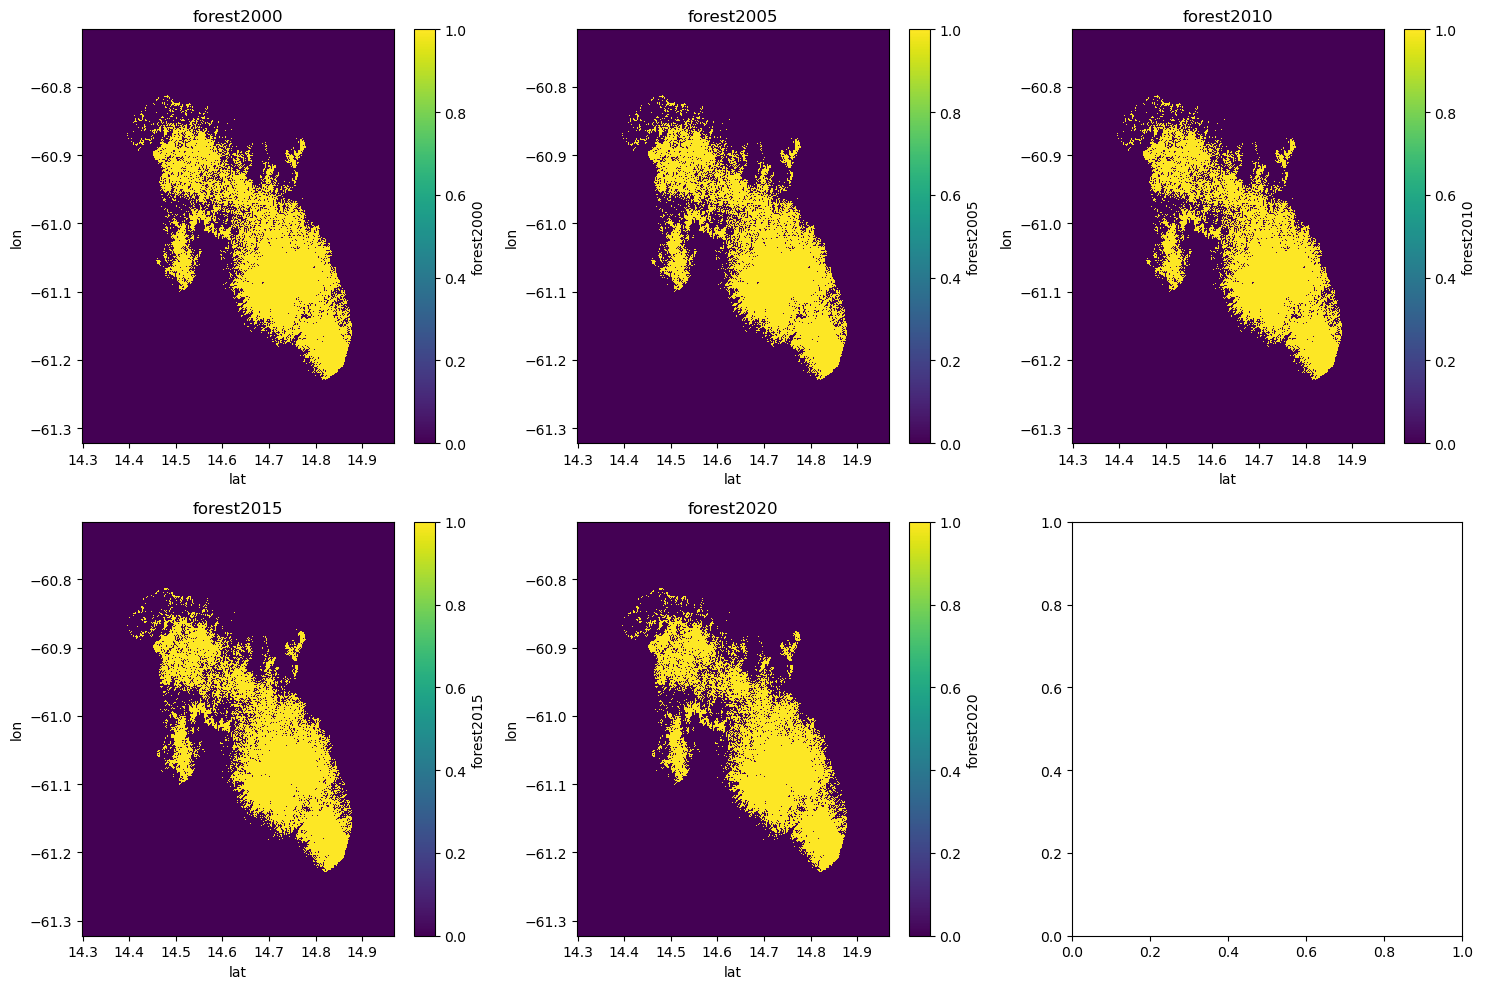

In [12]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))
for i, var in enumerate(forest.data_vars):
    forest[var].plot(ax=axs[i//3, i%3])
    axs[i//3, i%3].set_title(var)
plt.tight_layout()
plt.draw()


And now let's do a check of forest cover change over the years.

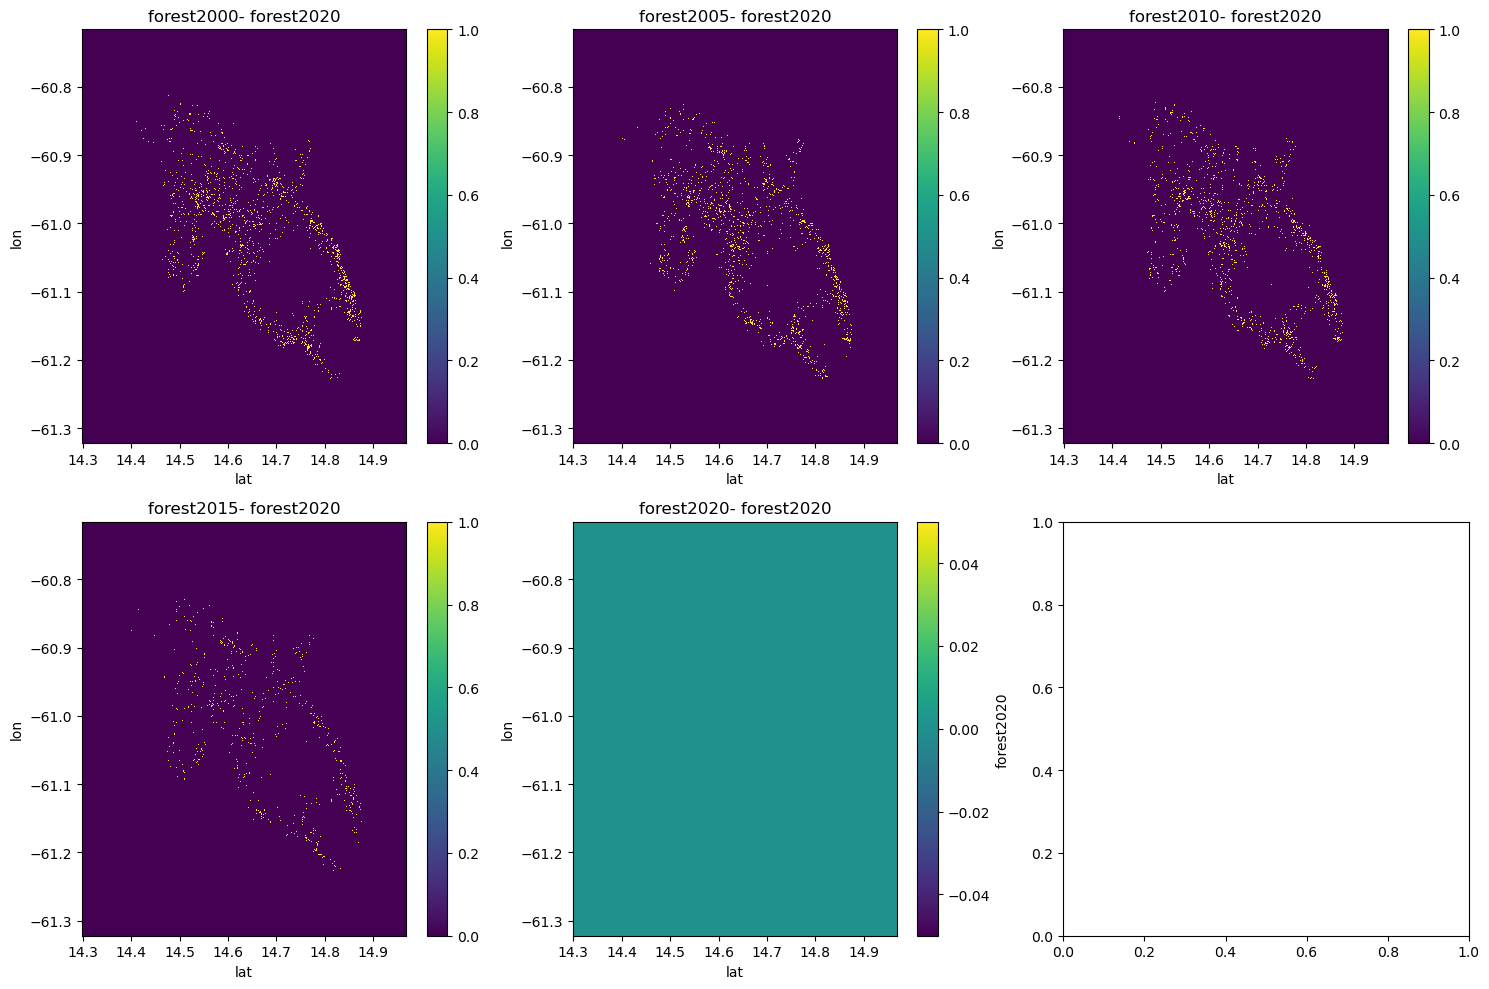

In [13]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))
for i, var in enumerate(forest.data_vars):
    (forest[var].astype(np.int32)-forest["forest2020"].astype(np.int32)).plot(ax=axs[i//3, i%3])
    axs[i//3, i%3].set_title(var + "- forest2020")
plt.tight_layout()
plt.draw()

Now let's save this file to disk.

In [19]:
forest.to_netcdf(f"forest_{iso3}.nc")
# Compression needs "netCDF4" to be installed
enc = {}
for k in forest.data_vars:
    enc[k] = {
            "zlib": True,
            "complevel": 8,
            "fletcher32": True,
            "chunksizes": tuple(map(lambda x: x//4, forest[k].shape))
        }
forest.to_netcdf(f"forest_{iso3}_compressed.nc", format="NETCDF4", engine="netcdf4", encoding=enc)
# With integer (no particular use here, but just in case)
enc = {}
for k in forest.data_vars:
    enc[k] = {
            "dtype": "int32",
        }
forest.to_netcdf(f"forest_{iso3}_integers.nc", format="NETCDF4", engine="netcdf4", encoding=enc)

enc = {}
for k in forest.data_vars:
    enc[k] = {
            "dtype": "int32",
            "zlib": True,
            "complevel": 8,
            "fletcher32": True,
            "chunksizes": tuple(map(lambda x: x//4, forest[k].shape))
        }
forest.to_netcdf(f"forest_{iso3}_integers_compressed.nc", format="NETCDF4", engine="netcdf4", encoding=enc)

In [20]:
print(str(os.path.getsize(f"forest_{iso3}.nc")/1e6) + " Mb")
print(str(os.path.getsize(f"forest_{iso3}_compressed.nc")/1e6) + " Mb")
print(str(os.path.getsize(f"forest_{iso3}_integers.nc")/1e6) + " Mb")
print(str(os.path.getsize(f"forest_{iso3}_integers_compressed.nc")/1e6) + " Mb")

27.385215 Mb
0.607555 Mb
109.450763 Mb
0.715879 Mb


### Raster oriented

Here we do some data manipulation and saving at the same time. Data manipulation is only done to be "raster-ready".

In [64]:
forest_date_list = [f"forest{i}" for i in date_list]
xr.concat(
    [forest[i] for i in forest_date_list],
    dim=pd.Index(forest_date_list, name="bands")
    ).\
    astype(np.int32).\
    rename({"lon": "x", "lat": "y"}).\
    transpose("bands", "y", "x").\
    rename("forest").\
    rio.write_crs("epsg:4326").\
    rio.to_raster(f"forest_{iso3}.tif")


In [65]:
print(str(os.path.getsize(f"forest_{iso3}.tif")/1e6) + " Mb")

109.436366 Mb


And we can have a look at the file we just saved.

In [66]:
!rio info forest_MTQ.tif

{"blockysize": 1, "bounds": [-61.32213496003556, 14.298204433825891, -60.7155885812242, 14.969113338085732], "colorinterp": ["gray", "undefined", "undefined", "undefined", "undefined"], "count": 5, "crs": "EPSG:4326", "descriptions": ["forest", "forest", "forest", "forest", "forest"], "driver": "GTiff", "dtype": "int32", "height": 2460, "indexes": [1, 2, 3, 4, 5], "interleave": "pixel", "lnglat": [-61.01886177062988, 14.63365888595581], "mask_flags": [["all_valid"], ["all_valid"], ["all_valid"], ["all_valid"], ["all_valid"]], "nodata": null, "res": [0.00027272768831446104, 0.00027272719685359425], "shape": [2460, 2224], "tiled": false, "transform": [0.00027272768831446104, 0.0, -61.32213496003556, 0.0, -0.00027272719685359425, 14.969113338085732, 0.0, 0.0, 1.0], "units": [null, null, null, null, null], "width": 2224}


In [67]:
rioxarray.open_rasterio(f"forest_{iso3}.tif")


<xarray.DataArray (band: 5, y: 2460, x: 2224)> Size: 109MB
[27355200 values with dtype=int32]
Coordinates:
  * band         (band) int64 40B 1 2 3 4 5
  * x            (x) float64 18kB -61.32 -61.32 -61.32 ... -60.72 -60.72 -60.72
  * y            (y) float64 20kB 14.97 14.97 14.97 14.97 ... 14.3 14.3 14.3
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      forest